In [6]:
from diffusers import LCMScheduler
model_id_or_path = "SimianLuo/LCM_Dreamshaper_v7"
from pipeline_pe import EditAllPipeline as EditPipeline
import os
import torch
from PIL import Image
import torch.nn.functional as nnf
from typing import Optional, Union, Tuple, List, Callable, Dict
import abc
import ptp_utils
import numpy as np
import seq_aligner
import math
from diffusers import UNet2DConditionModel, DiffusionPipeline, LCMScheduler
import torch, cv2
from PIL import Image
import copy

device = "cuda:1" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float32
scheduler = LCMScheduler.from_config(model_id_or_path, subfolder="scheduler")
pipe = EditPipeline.from_pretrained(model_id_or_path, scheduler=scheduler, requires_safety_checker=False, torch_dtype=torch_dtype)

tokenizer = pipe.tokenizer
encoder = pipe.text_encoder
LOW_RESOURCE = False
MAX_NUM_WORDS = 77
if torch.cuda.is_available():
    pipe = pipe.to(device)
class AttentionControl(abc.ABC):

    def step_callback(self, x_t):
        return x_t

    def between_steps(self):
        return

    @property
    def num_uncond_att_layers(self):
        return self.num_att_layers if LOW_RESOURCE else 0

    @abc.abstractmethod
    def forward(self, attn, is_cross: bool, place_in_unet: str):
        raise NotImplementedError

    def __call__(self, attn, is_cross: bool, place_in_unet: str):
        if self.cur_att_layer >= self.num_uncond_att_layers:
            if LOW_RESOURCE:
                attn = self.forward(attn, is_cross, place_in_unet)
            else:
                h = attn.shape[0]
                attn[h // 2:] = self.forward(attn[h // 2:], is_cross, place_in_unet)
        self.cur_att_layer += 1
        if self.cur_att_layer == self.num_att_layers // 2 + self.num_uncond_att_layers:
            self.cur_att_layer = 0
            self.cur_step += 1
            self.between_steps()
        return attn

    def reset(self):
        self.cur_step = 0
        self.cur_att_layer = 0

    def __init__(self):
        self.cur_step = 0
        self.num_att_layers = -1
        self.cur_att_layer = 0


class EmptyControl(AttentionControl):

    def forward(self, attn, is_cross: bool, place_in_unet: str):
        return attn
    def self_attn_forward(self, q, k, v, sim, attn, is_cross, place_in_unet, num_heads, **kwargs):
        b = q.shape[0] // num_heads
        out = torch.einsum("h i j, h j d -> h i d", attn, v)
        return out
        


class AttentionStore(AttentionControl):

    @staticmethod
    def get_empty_store():
        return {"down_cross": [], "mid_cross": [], "up_cross": [],
                "down_self": [],  "mid_self": [],  "up_self": []}

    def forward(self, attn, is_cross: bool, place_in_unet: str):
        key = f"{place_in_unet}_{'cross' if is_cross else 'self'}"
        if attn.shape[1] <= 32 ** 2:  # avoid memory overhead
            self.step_store[key].append(attn)
        return attn

    def between_steps(self):
        if len(self.attention_store) == 0:
            self.attention_store = self.step_store
        else:
            for key in self.attention_store:
                for i in range(len(self.attention_store[key])):
                    self.attention_store[key][i] += self.step_store[key][i]
        self.step_store = self.get_empty_store()

    def get_average_attention(self):
        average_attention = {key: [item / self.cur_step for item in self.attention_store[key]] for key in self.attention_store}
        return average_attention

    def reset(self):
        super(AttentionStore, self).reset()
        self.step_store = self.get_empty_store()
        self.attention_store = {}

    def __init__(self):
        super(AttentionStore, self).__init__()
        self.step_store = self.get_empty_store()
        self.attention_store = {}


class LocalBlend:
    def get_mask(self,x_t,maps,word_idx, thresh, i):
        maps = maps * word_idx.reshape(1,1,1,1,-1)
        maps = (maps[:,:,:,:,1:self.len-1]).mean(0,keepdim=True)
        # maps = maps.mean(0,keepdim=True)
        maps = (maps).max(-1)[0]
        # self.save_image(maps,i,"map")
        maps = nnf.interpolate(maps, size=(x_t.shape[2:]))
        # maps = maps.mean(1,keepdim=True)\
        maps = maps / maps.max(2, keepdim=True)[0].max(3, keepdim=True)[0]
        mask = maps > thresh
        return mask

    def save_image(self,mask, i, caption):
        image = mask[0, 0, :, :]
        image = 255 * image / image.max()
        # print(image.shape)
        image = image.unsqueeze(-1).expand(*image.shape, 3)
        # print(image.shape)
        image = image.cpu().numpy().astype(np.uint8)
        image = np.array(Image.fromarray(image).resize((256, 256)))
        if not os.path.exists(f"inter/{caption}"):
           os.mkdir(f"inter/{caption}") 
        ptp_utils.save_images(image, f"inter/{caption}/{i}.jpg")
        
    def __call__(self, i, x_s, x_t, x_m, attention_store, alpha_prod, temperature=0.15, use_xm=False, mn=0):
        maps = attention_store["down_cross"][2:4] + attention_store["up_cross"][:3]
        h,w = x_t.shape[2],x_t.shape[3]
        h , w = ((h+1)//2+1)//2, ((w+1)//2+1)//2
        # print(h,w)
        # print(maps[0].shape)
        maps = [item.reshape(2, -1, 1, h // int((h*w/item.shape[-2])**0.5),  w // int((h*w/item.shape[-2])**0.5), MAX_NUM_WORDS) for item in maps]
        maps = torch.cat(maps, dim=1)
        maps_s = maps[0,:]
        maps_m = maps[1,:]
        thresh_e = temperature / alpha_prod ** (0.5)
        if thresh_e < self.thresh_e:
          thresh_e = self.thresh_e
        thresh_m = self.thresh_m
        mask_e = self.get_mask(x_t, maps_m, self.alpha_e, thresh_e, i)
        mask_m = self.get_mask(x_t, maps_s, (self.alpha_m-self.alpha_me), thresh_m, i)
        mask_me = self.get_mask(x_t, maps_m, self.alpha_me, self.thresh_e, i)
        if self.save_inter:
            self.save_image(mask_e,i,"mask_e_"+str(mn))
            self.save_image(mask_m,i,"mask_m_"+str(mn))
            self.save_image(mask_me,i,"mask_me_"+str(mn))

        if self.alpha_e.sum() == 0:
          x_t_out = x_t
        else:
          x_t_out = torch.where(mask_e, x_t, x_m)
        x_t_out = torch.where(mask_m, x_s, x_t_out)
        if use_xm:
          x_t_out = torch.where(mask_me, x_m, x_t_out)
        
        return x_m, x_t_out

    def __init__(self,thresh_e=0.3, thresh_m=0.3, save_inter = False):
        self.thresh_e = thresh_e
        self.thresh_m = thresh_m
        self.save_inter = save_inter
        
    def set_map(self, ms, alpha, alpha_e, alpha_m,len):
        self.m = ms
        self.alpha = alpha
        self.alpha_e = alpha_e
        self.alpha_m = alpha_m
        alpha_me = alpha_e.to(torch.bool) & alpha_m.to(torch.bool)
        self.alpha_me = alpha_me.to(torch.float)
        self.len = len

class AttentionControlEdit(AttentionStore, abc.ABC):
    def step_callback(self,i, t, x_s, x_t, x_m, alpha_prod,mn=0):
        # import pdb; pdb.set_trace()
        if (self.local_blend is not None) and (i>0):
            use_xm = (self.cur_step+self.start_steps+1 == self.num_steps)
            x_m, x_t = self.local_blend(i, x_s, x_t, x_m, self.attention_store, alpha_prod, use_xm=use_xm,mn=mn)
        return x_m, x_t

    def replace_self_attention(self, attn_base, att_replace):
        if att_replace.shape[2] <= 16 ** 2:
            return attn_base.unsqueeze(0).expand(att_replace.shape[0], *attn_base.shape)
        else:
            return att_replace

    @abc.abstractmethod
    def replace_cross_attention(self, attn_base, att_replace):
        raise NotImplementedError
    
    def attn_batch(self, q, k, v, sim, attn, is_cross, place_in_unet, num_heads, **kwargs):
        b = q.shape[0] // num_heads

        sim = torch.einsum("h i d, h j d -> h i j", q, k) * kwargs.get("scale")
        attn = sim.softmax(-1)
        out = torch.einsum("h i j, h j d -> h i d", attn, v)
        return out
        
    def self_attn_forward(self, qu, qc, ku, kc, vu= None, vc= None, num_heads= None):
        
        flag = False
        if num_heads == None:
            flag = True
            num_heads = kc
            vu, vc = ku.chunk(2)
            ku, kc = qc.chunk(2)
            qu, qc = qu.chunk(2)
            
        if (self.self_replace_steps <= ((self.cur_step+self.start_steps+1)*1.0 / self.num_steps) ):
            qu=torch.cat([qu[:num_heads*2],qu[num_heads:num_heads*2]])
            qc=torch.cat([qc[:num_heads*2],qc[num_heads:num_heads*2]])
            ku=torch.cat([ku[:num_heads*2],ku[:num_heads]])
            kc=torch.cat([kc[:num_heads*2],kc[:num_heads]])
            vu=torch.cat([vu[:num_heads*2],vu[:num_heads]])
            vc=torch.cat([vc[:num_heads*2],vc[:num_heads]])
        else:
            qu=torch.cat([qu[:num_heads],qu[:num_heads],qu[:num_heads]])
            qc=torch.cat([qc[:num_heads],qc[:num_heads],qc[:num_heads]])
            ku=torch.cat([ku[:num_heads],ku[:num_heads],ku[:num_heads]])
            kc=torch.cat([kc[:num_heads],kc[:num_heads],kc[:num_heads]])
            vu=torch.cat([vu[:num_heads*2],vu[:num_heads]])
            vc=torch.cat([vc[:num_heads*2],vc[:num_heads]])
        if not flag:
            return qu, qc, ku, kc, vu, vc
        else:
            return torch.cat([qu, qc], dim=0) ,torch.cat([ku, kc], dim=0), torch.cat([vu, vc], dim=0)
            
    def forward(self, attn, is_cross: bool, place_in_unet: str):
        if is_cross :
            h = attn.shape[0] // self.batch_size
            attn = attn.reshape(self.batch_size,h,  *attn.shape[1:])
            attn_base, attn_repalce, attn_masa = attn[0], attn[1], attn[2]
            attn_replace_new = self.replace_cross_attention(attn_masa, attn_repalce) 
            attn_base_store = self.replace_cross_attention(attn_base, attn_repalce)
            if (self.cross_replace_steps >= ((self.cur_step+self.start_steps+1)*1.0 / self.num_steps) ):
                attn[1] = attn_base_store
            if not self.is_replace:
                attn_store=torch.cat([attn_base_store,attn_replace_new])
            else:
                attn_store=torch.cat([attn_base_store,attn_base_store])
                
            attn = attn.reshape(self.batch_size * h, *attn.shape[2:])
            attn_store = attn_store.reshape(2 *h, *attn_store.shape[2:])
            super(AttentionControlEdit, self).forward(attn_store, is_cross, place_in_unet)
        return attn

    def __init__(self, prompts, num_steps: int,start_steps: int,
                 cross_replace_steps: Union[float, Tuple[float, float], Dict[str, Tuple[float, float]]],
                 self_replace_steps: Union[float, Tuple[float, float]],
                 local_blend: Optional[LocalBlend]):
        super(AttentionControlEdit, self).__init__()
        self.batch_size = len(prompts)+1
        self.self_replace_steps = self_replace_steps
        self.cross_replace_steps = cross_replace_steps
        self.num_steps=num_steps
        self.start_steps=start_steps
        self.local_blend = local_blend


class AttentionReplace(AttentionControlEdit):

    def replace_cross_attention(self, attn_base, att_replace):
        return torch.einsum('hpw,bwn->bhpn', attn_base, self.mapper)

    def __init__(self, prompts, num_steps: int, cross_replace_steps: float, self_replace_steps: float,
                 local_blend: Optional[LocalBlend] = None):
        super(AttentionReplace, self).__init__(prompts, num_steps, cross_replace_steps, self_replace_steps, local_blend)
        self.mapper = seq_aligner.get_replacement_mapper(prompts, tokenizer).to(device).to(torch_dtype)


class AttentionRefine(AttentionControlEdit):
    def replace_cross_attention(self, attn_masa, att_replace):
        if self.is_replace:
            # import pdb; pdb.set_trace()
            return torch.einsum('hpw,bwn->bhpn', attn_masa, self.replacemapper)
        # import pdb; pdb.set_trace()
        attn_masa_replace = attn_masa[:, :, self.mapper].squeeze()
        attn_replace = attn_masa_replace * self.alphas + \
                 att_replace * (1 - self.alphas)
        return attn_replace

    def __init__(self, prompts, prompt_specifiers, num_steps: int,start_steps: int, cross_replace_steps: float, self_replace_steps: float,
                 local_blend: Optional[LocalBlend] = None, is_replace=False):
        super(AttentionRefine, self).__init__(prompts, num_steps,start_steps, cross_replace_steps, self_replace_steps, local_blend)
        self.mapper, alphas, ms, alpha_e, alpha_m = seq_aligner.get_refinement_mapper(prompts, prompt_specifiers, tokenizer, encoder, device)
        self.mapper, alphas, ms = self.mapper.to(device), alphas.to(device).to(torch_dtype), ms.to(device).to(torch_dtype)
        self.alphas = alphas.reshape(alphas.shape[0], 1, 1, alphas.shape[1])
        self.ms = ms.reshape(ms.shape[0], 1, 1, ms.shape[1])
        ms = ms.to(device)
        alpha_e = alpha_e.to(device)
        alpha_m = alpha_m.to(device)
        t_len = len(tokenizer(prompts[1])["input_ids"])
        # import pdb; pdb.set_trace()
        self.prompts = prompts
        self.prompt_specifiers = prompt_specifiers
        self.local_blend.set_map(ms,alphas,alpha_e,alpha_m,t_len)
        self.is_replace=is_replace
        if is_replace:
            self.replacemapper = seq_aligner.get_replacement_mapper(prompts, tokenizer).to(device).to(torch_dtype)

def get_equalizer(text: str, word_select: Union[int, Tuple[int, ...]], values: Union[List[float], Tuple[float, ...]]):
    if type(word_select) is int or type(word_select) is str:
        word_select = (word_select,)
    equalizer = torch.ones(len(values), 77)
    values = torch.tensor(values, dtype=torch_dtype)
    for word in word_select:
        inds = ptp_utils.get_word_inds(text, word, tokenizer)
        equalizer[:, inds] = values
    return equalizer


def inference(img, source_prompt, target_prompt,
          local, mutual,
          positive_prompt, negative_prompt,
          guidance_s, guidance_t,
          num_inference_steps,
          width, height, seed, strength,          
          cross_replace_steps, self_replace_steps, 
          thresh_e, thresh_m, denoise, user_instruct="", api_key="",shape_change=[]):

    if user_instruct != "" and api_key != "":
        source_prompt, target_prompt, local, mutual, replace_steps, num_inference_steps = get_params(api_key, user_instruct)
        cross_replace_steps = replace_steps
        self_replace_steps = replace_steps

    assert len(target_prompt) == len(local)
    torch.manual_seed(seed)
    ratio = min(height / img.height, width / img.width)
    img = img.resize((int(img.width * ratio), int(img.height * ratio)))
    if denoise is False:
        strength = 1
    num_denoise_num = math.trunc(num_inference_steps*strength)
    num_start = num_inference_steps-num_denoise_num
    # create the CAC controller.
    local_blends = [LocalBlend(thresh_e=thresh_e, thresh_m=thresh_m, save_inter=False) for i in range(len(local))]
    prompt_list = [source_prompt] + target_prompt
    # is_replace_list = [True if len(prompt_list[i])==len(prompt_list[i+1]) else False for i in range(len(local)) ]
    # is_replace_list = [False, False, False]
    is_replace_list = [True if (len(prompt_list[i].split(" "))==len(prompt_list[i+1].split(" ")) and i not in shape_change) else False for i in range(len(local)) ] ###TODO
    self_attn_list = [i if i not in shape_change else None for i in range(len(local))]
    controller = [AttentionRefine([prompt_list[i], prompt_list[i+1]],[[local[i], mutual]],
                    num_inference_steps,
                    num_start,
                    cross_replace_steps=cross_replace_steps,
                    self_replace_steps=self_replace_steps,
                    local_blend=local_blends[i], is_replace=is_replace_list[i]
                    ) for i in range(len(local))]
    callbacks = None
    callbacks = [c.step_callback for c in controller]
    ptp_utils.register_attention_control_all(pipe, controller, self_attn_list=[1,0])

    results = pipe(prompt=target_prompt,
                   source_prompt=source_prompt,
                   positive_prompt=positive_prompt,
                   negative_prompt=negative_prompt,
                   image=img,
                   num_inference_steps=num_inference_steps,
                   eta=1,
                   strength=strength,
                   guidance_scale=guidance_t,
                   source_guidance_scale=guidance_s,
                   denoise_model=denoise,
                   callback = callbacks
                   )
    att1=show_cross_attention(controller[0], 16, ["up", "down"],prompts=[target_prompt[0]])
    att2=show_cross_attention(controller[1], 16, ["up", "down"],prompts=[target_prompt[1]])
    return results,att1, att2


def aggregate_attention(attention_store: AttentionStore, res: int, from_where: List[str], is_cross: bool, select: int, prompts: list):
    out = []
    attention_maps = attention_store.get_average_attention()
    # import pdb; pdb.set_trace()
    num_pixels = res ** 2
    for location in from_where:
        for item in attention_maps[f"{location}_{'cross' if is_cross else 'self'}"]:
            if item.shape[1] == num_pixels:
                cross_maps = item.reshape(len(prompts), -1, res, res, item.shape[-1])[select]
                out.append(cross_maps)
                
    out = torch.cat(out, dim=0)
    out = out.sum(0) / out.shape[0]
    return out.cpu()
    
def text_under_image(image: np.ndarray, text: str, text_color: Tuple[int, int, int] = (0, 0, 0)):
    h, w, c = image.shape
    offset = int(h * .2)
    img = np.ones((h + offset, w, c), dtype=np.uint8) * 255
    font = cv2.FONT_HERSHEY_SIMPLEX
    # font = ImageFont.truetype("/usr/share/fonts/truetype/noto/NotoMono-Regular.ttf", font_size)
    img[:h] = image
    textsize = cv2.getTextSize(text, font, 1, 2)[0]
    text_x, text_y = (w - textsize[0]) // 2, h + offset - textsize[1] // 2
    cv2.putText(img, text, (text_x, text_y ), font, 1, text_color, 2)
    return img

def view_images(images, num_rows=1, offset_ratio=0.02):
    from IPython.display import display
    if type(images) is list:
        num_empty = len(images) % num_rows
    elif images.ndim == 4:
        num_empty = images.shape[0] % num_rows
    else:
        images = [images]
        num_empty = 0

    empty_images = np.ones(images[0].shape, dtype=np.uint8) * 255
    images = [image.astype(np.uint8) for image in images] + [empty_images] * num_empty
    num_items = len(images)

    h, w, c = images[0].shape
    offset = int(h * offset_ratio)
    num_cols = num_items // num_rows
    image_ = np.ones((h * num_rows + offset * (num_rows - 1),
                      w * num_cols + offset * (num_cols - 1), 3), dtype=np.uint8) * 255
    for i in range(num_rows):
        for j in range(num_cols):
            image_[i * (h + offset): i * (h + offset) + h:, j * (w + offset): j * (w + offset) + w] = images[
                i * num_cols + j]

    pil_img = Image.fromarray(image_)
    display(pil_img)
    
def show_cross_attention(attention_store: AttentionStore, res: int, from_where: List[str], select: int = 0, prompts=''):
    tokens = tokenizer.encode(prompts[select])
    decoder = tokenizer.decode
    attention_maps = aggregate_attention(attention_store, res, from_where, True, select, prompts)
    images = {}
    for i in range(len(tokens)):
        image = attention_maps[:, :, i]
        image = 255 * image / image.max()
        image = image.unsqueeze(-1).expand(*image.shape, 3)
        image = image.numpy().astype(np.uint8)
        image = np.array(Image.fromarray(image).resize((256, 256)))
        image = text_under_image(image, decoder(int(tokens[i])))
        images[decoder(int(tokens[i]))]=image
        
    view_images(np.stack(images.values(), axis=0))
    return images

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [7]:
def calculate_iou(pred_mask, true_mask,  threshold):
    """
    Calculate Intersection over Union (IOU) between two masks.
    """
    pred_mask = pred_mask > threshold
    true_mask = true_mask > threshold

    intersection = np.logical_and(pred_mask, true_mask)
    union = np.logical_or(pred_mask, true_mask)

    iou = np.sum(intersection) / min(np.sum(pred_mask), np.sum(true_mask))
    return iou

def calculate_miou(dict1, dict2, pred_keys, true_keys, m):
    """
    Calculate mean Intersection over Union (mIOU) between two images.
    """
    pred_keys = pred_keys.split()
    true_keys = true_keys.split()

    image1 = np.zeros_like(dict1["<|startoftext|>"])
    image2 = np.zeros_like(dict2["<|startoftext|>"])
    for pred_key in pred_keys:
        image1 += dict1[pred_key]
    for true_key in true_keys:
        image2 += dict2[true_key]

    # import pdb; pdb.set_trace()
    image1 =  image1.astype("float32")/len(pred_keys)
    image2 = image2.astype("float32") / len(true_keys)
    
    assert image1.shape == image2.shape, "Image shapes must be equal"
    
    iou_values = []
    for threshold in range(m-10, m+10):
        iou = calculate_iou(image1, image2, threshold)
        iou_values.append(iou)

    mIOU = np.mean(iou_values)
    return mIOU

def aspect_clustering(ac, objs):
    threshold = 100
    objs = copy.deepcopy(objs)
    pairs = []
    while len(objs) > 0:
        base = objs[0]
        pair = [base]
        if base not in ac[2]:
            del objs[0]
            continue
        for i in range(len(objs)-1, 0, -1):
            if calculate_miou(ac[2], ac[2], base, objs[i], threshold):
                pair.append(objs[i])
                del objs[i]
        del objs[0]
        pairs.append(pair)

    return pairs

def update_position(dataset, offset, pos):
    for key in dataset['editing'].keys():
        if dataset['editing'][key]["position"] >= pos:
            dataset['editing'][key]["position"] += offset
    return dataset

def generate_editing_prompt(dataset, object_list):
    original_prompt = dataset['source_prompt'].replace("[", "").replace("]", "")
    editing_prompts = original_prompt
    keys = list(dataset['editing'])
    for word in keys:
        word = str(word)
        position, edit_type, action_word = dataset['editing'][word]["position"], dataset['editing'][word]["edit_type"], dataset['editing'][word]["action"]
        adjs = [dataset['obj-adj-pair'][obj] for obj in object_list]
        adjs = [x  for xs in adjs for x in xs] 

        
        if word not in object_list and word not in adjs:
            word_list = word.split()
            is_exist = False
            if len(word_list) > 0:
                for w in word_list:
                    if w in object_list or w in adjs:
                        is_exist = True
                        break
            if not is_exist:
                continue
        word_count = word.count(" ") + 1
        if action_word == "+":
            current_sentence = editing_prompts.split()
            current_sentence.insert(position, f"{word}")
            editing_prompts = " ".join(current_sentence)
            # import pdb;pdb.set_trace()
            dataset = update_position(dataset, word_count, position)
            # 
        elif action_word == "-":
            editing_prompts = editing_prompts.replace(word+" ", "", 1)
            dataset = update_position(dataset, -word_count, position)
        else:
            editing_prompts = editing_prompts.replace(action_word, word, 1)
            dataset = update_position(dataset, word_count - action_word.count(" ") - 1, position)

        del dataset['editing'][word]
        dataset['source_prompt'] = editing_prompts
    return editing_prompts, dataset

def get_obj_pair(dataset):
    dataset = copy.deepcopy(dataset)
    obj_pairs = []
    for obj in dataset['obj-adj-pair'].keys():
        if obj in dataset['editing']:
            action = dataset['editing'][obj]['action']
            if action == '-' or action == '+':
                obj_pairs.append([obj])
            else:
                obj_pairs.append([action, obj])
            del dataset['editing'][obj]
        else:
            keys = list(dataset['editing'].keys())
            for key in keys:           
                if obj in key:
                    action = dataset['editing'][key]['action']
                    if action == '-' or action == '+':
                        obj_pairs.append([obj])
                    else:
                        obj_pairs.append([action, obj])
                    del dataset['editing'][key]
    global_edits = list(dataset['editing'].keys())
    
    for i in range(len(global_edits)-1, -1, -1):
        for _, v in dataset["obj-adj-pair"].items():
            if global_edits[i] in v:
                del global_edits[i]
                break
             
    return obj_pairs, global_edits

def get_edits_type(ac, obj_pairs, global_edit):
    non_rigid_obj = []
    rigid_obj = []
    threshold = 100
    for i, obj_pair in enumerate(obj_pairs):
        if obj_pair[-1] in ac[2] and (ac[2][obj_pair[-1]] > threshold).sum() >= 0.8 * np.ones_like(ac[2][obj_pair[-1]]).sum():
            global_edit.append(obj_pair[-1])
        elif len(obj_pair) == 1:
            non_rigid_obj.append(obj_pair[0])
        elif calculate_miou(ac[1], ac[2], obj_pair[0], obj_pair[1],threshold) < 0.9:
            non_rigid_obj.append(obj_pair[1])
        else:
            rigid_obj.append(obj_pair[1])
        # print( non_rigid_obj, rigid_obj, global_edit)
    return non_rigid_obj, rigid_obj, global_edit

In [8]:
dataset = {
    "image_path": "example.jpg",
    "source_prompt": "a man sitting in a boat is silhouetted against the sunset with mountain in the background",
    "target_prompt": "a man standing in a boat is silhouetted against the sunset and ducks on the water with Alps mountain in the background",
    "editing":{"man standing":{"position":2,"edit_type":5,"action":"man sitting"}, "ducks on the water":{"position":11,"edit_type":2,"action":"+"},"Alps mountain":{"position":12,"edit_type":1,"action":"mountain"}},
    "obj-adj-pair":{"man":["standing"],"ducks":[],"mountain":["Alps"]}}
    

In [9]:
img, source_prompt, target_prompt, \
          local, mutual, \
          positive_prompt, negative_prompt, \
          guidance_s, guidance_t, \
          test_num_inference_steps,num_inference_steps, \
          width, height, seed, strength,           \
          cross_replace_steps, self_replace_steps,  \
          thresh_e, thresh_m, denoise = dataset['image_path'], \
            dataset['source_prompt'], [dataset['source_prompt'], dataset['target_prompt'].replace("[", "").replace("]", "")], ["",""],  \
            "","","",1,[3],5, 15,512,512,0,1,0.7,0.7,0.5,0.8,False

  0%|          | 0/5 [00:00<?, ?it/s]

/tmp/ipykernel_1021878/3668153605.py:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  aspect_cluters = inference(img_file, source_prompt, target_prompt,


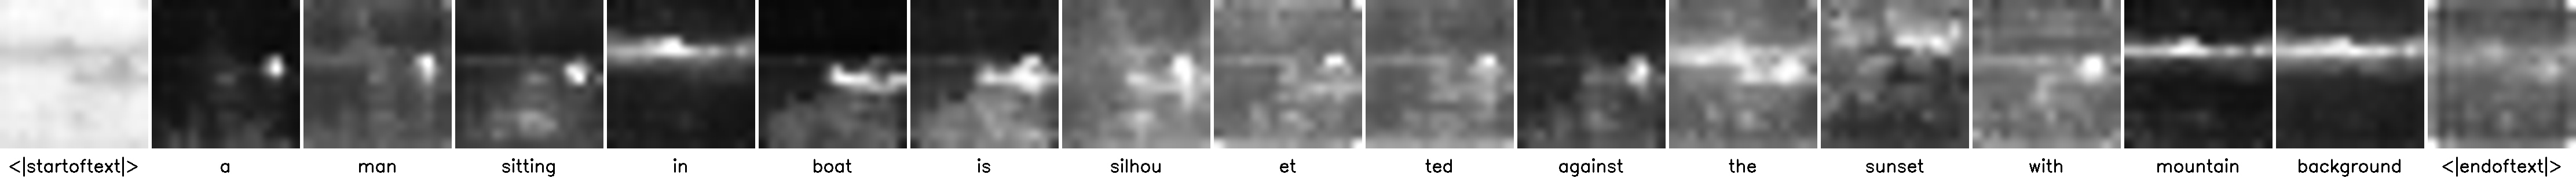

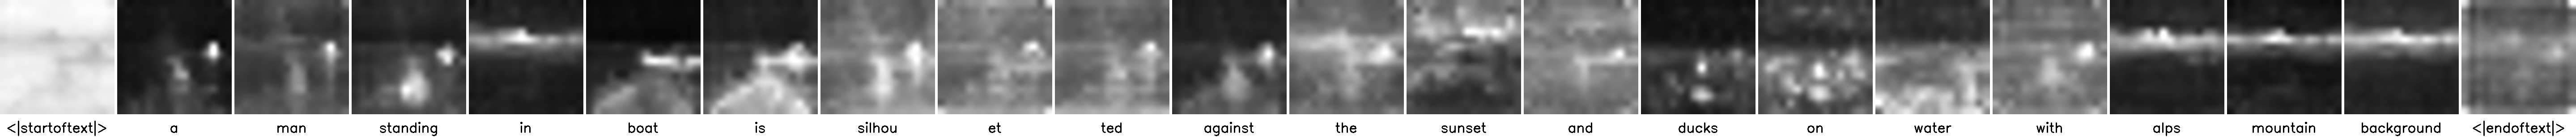

In [10]:
img_file = Image.open(img).resize((width, height))
### for aspect clustering
aspect_cluters = inference(img_file, source_prompt, target_prompt,
          local, mutual,
          positive_prompt, negative_prompt,
          guidance_s, guidance_t,
          test_num_inference_steps, #num_inference_steps,
          width, height, seed, strength,          
          cross_replace_steps, self_replace_steps, 
          thresh_e, thresh_m, denoise,[1])

In [11]:
obj_pairs, global_edit = get_obj_pair(dataset)
non_rigid_obj, rigid_obj, global_edit = get_edits_type(aspect_cluters, obj_pairs, global_edit)
rigid_objs = aspect_clustering(aspect_cluters, rigid_obj)
non_rigid_objs = aspect_clustering(aspect_cluters, non_rigid_obj)


In [13]:
editing_prompts = []
blended_word_list = []
for obj in rigid_objs:
    editing_prompt, dataset = generate_editing_prompt(dataset,obj)
    blended_word_list.append(" ".join(obj))
    editing_prompts.append(editing_prompt)
rigid_num = len(editing_prompts)

for obj in non_rigid_objs:
    editing_prompt, dataset = generate_editing_prompt(dataset,obj)
    blended_word_list.append(" ".join(obj))
    editing_prompts.append(editing_prompt)

if len(global_edit) > 0:
    for obj in [global_edit]:
        editing_prompt, dataset = generate_editing_prompt(dataset,obj)
        blended_word_list.append("")
        editing_prompts.append(editing_prompt)

  0%|          | 0/15 [00:00<?, ?it/s]

/tmp/ipykernel_1021878/2756150274.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  results = inference(img_file, source_prompt, editing_prompts,


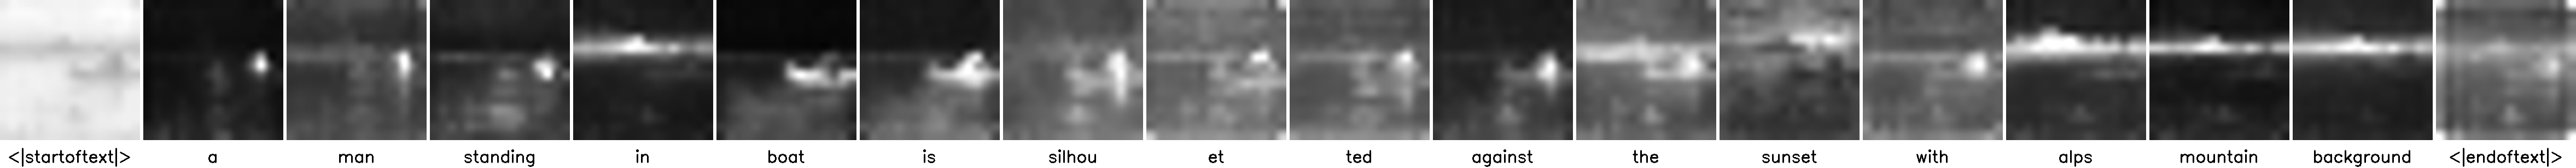

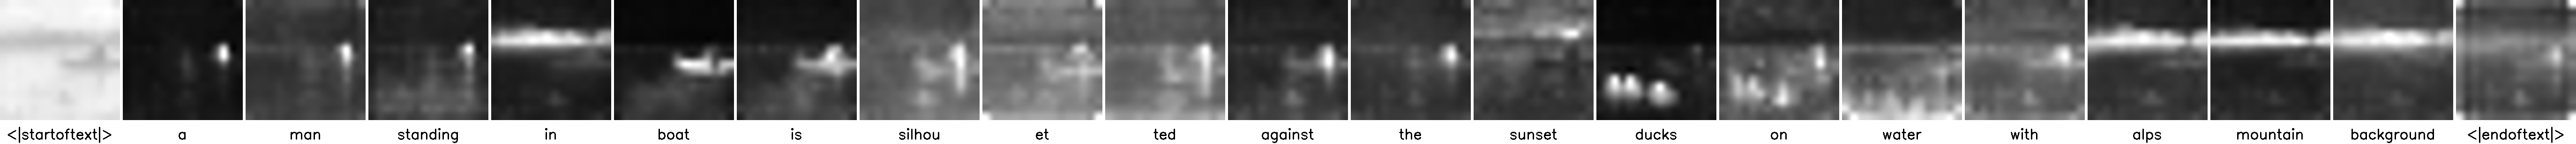

In [14]:
results = inference(img_file, source_prompt, editing_prompts,
          blended_word_list, mutual,
          positive_prompt, negative_prompt,
          guidance_s, guidance_t,
          num_inference_steps, 
          width, height, seed, strength,          
          cross_replace_steps, self_replace_steps, 
          thresh_e, thresh_m, denoise,list(range(rigid_num,len(editing_prompts))))

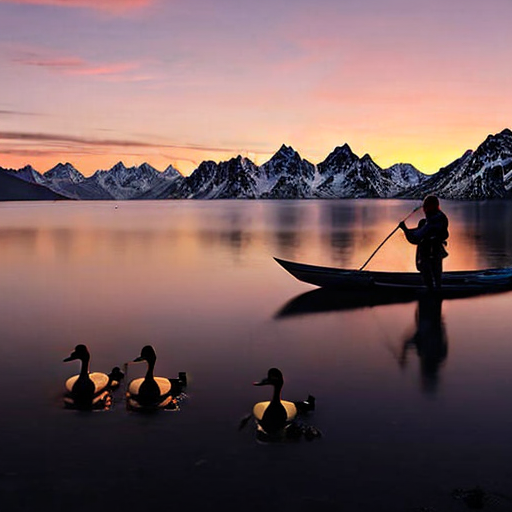

In [15]:
results[0]['target_image'][-1]